In [ ]:
import os
import numpy as np  # Importing numpy for Matrix Operations
import pandas as pd  # Importing pandas to read CSV files
import matplotlib.pyplot as plt # Importting matplotlib for Plotting and visualizing images
import math # Importing math module to perform mathematical operations
import cv2 # Importing openCV for image processing
import seaborn as sns # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

#Sklearn modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


# Display images using OpenCV
from google.colab.patches import cv2_imshow

#Imports functions for evaluating the performance of machine learning models
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score, recall_score, precision_score, classification_report
from sklearn.metrics import mean_squared_error as mse

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
tf.keras.utils.set_random_seed(812)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()

LOADING THE DATA

In [ ]:
 from google.colab import drive
 drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
images = np.load('/content/drive/MyDrive/Great Learning/images_proj.npy')
labels = pd.read_csv('/content/drive/MyDrive/Great Learning/Labels_proj.csv')

DATA OVERVIEW

In [ ]:
print(images.shape)
print(labels.shape)

(631, 200, 200, 3)
(631, 1)


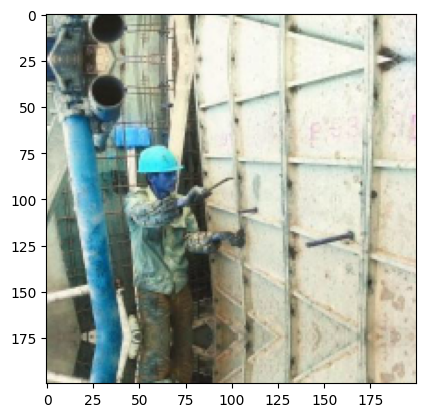

In [ ]:
plt.imshow(images[3])

EXPLORATORY DATA ANALYSIS

In [ ]:
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

In [ ]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

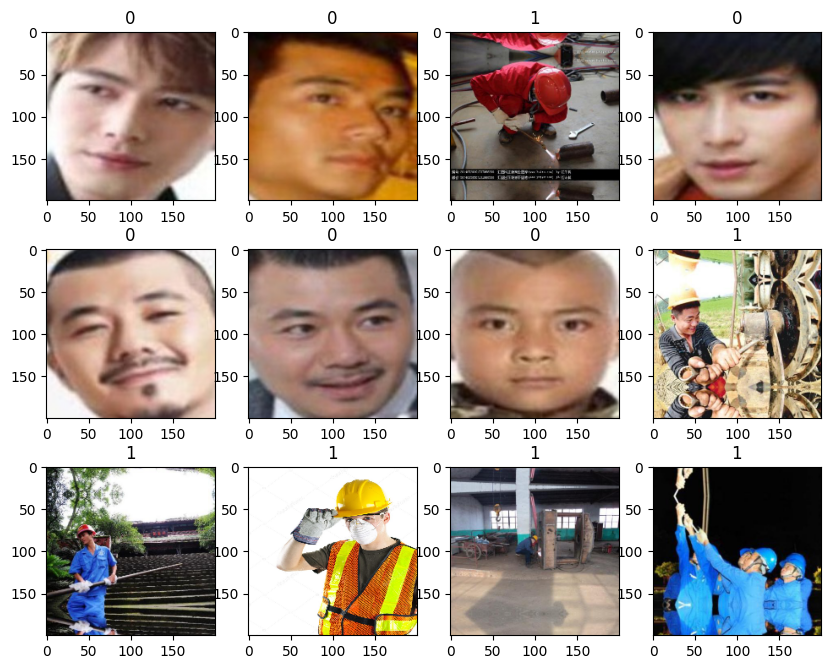

In [ ]:
plot_images(images,labels)

CHECKING FOR DATA IMBALANCE

In [ ]:
print(labels['Label'].value_counts())
print("Unique labels:", labels['Label'].unique())

Label
0    320
1    311
Name: count, dtype: int64
Unique labels: [1 0]


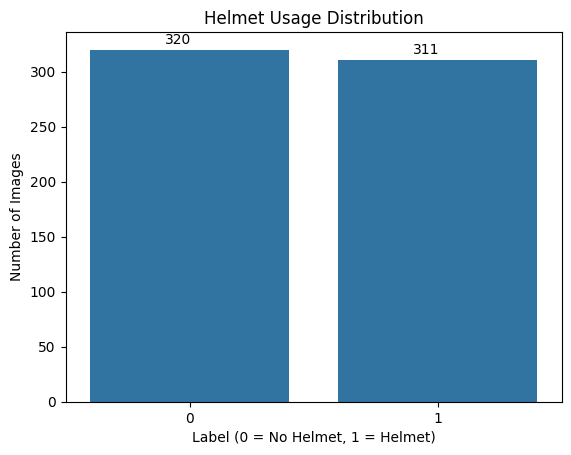

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a countplot for helmet vs no helmet
sns.countplot(x=labels['Label'])

# Add labels and title
plt.title('Helmet Usage Distribution')
plt.xlabel('Label (0 = No Helmet, 1 = Helmet)')
plt.ylabel('Number of Images')

# Optional: annotate the counts on top of bars
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + 0.3, p.get_height() + 5))

# Show plot
plt.show()

DATA PREPROCESSING FOR ANN ALONE

In [ ]:
images_decreased = []
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

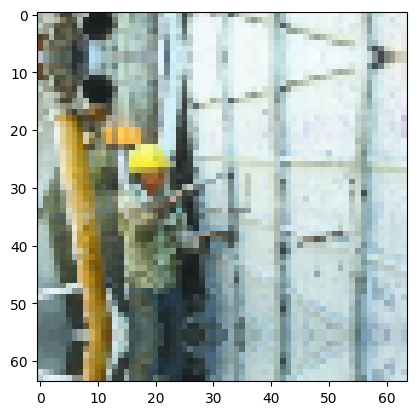

In [ ]:
plt.imshow(images_decreased[3]);

SPLITTING THE ORIGINAL DATA

In [ ]:
X_train_rgb, X_temp_rgb, y_train_rgb, y_temp_rgb = train_test_split(np.array(images_decreased),labels , test_size=0.2, random_state=42,stratify=labels)
# Splitting the temporary set further into validation (50%) and test (50%) sets
# This results in 10% validation and 10% test data from the original dataset
X_val_rgb, X_test_rgb, y_val_rgb, y_test_rgb = train_test_split(X_temp_rgb,y_temp_rgb , test_size=0.5, random_state=42,stratify=y_temp_rgb)

Applying GRAY SCALE and Gaussian blur on the original data

In [ ]:
import cv2
import numpy as np

# Input: images_decreased (assumed to be RGB images)
images_gray_blur = []

for img in images_decreased:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)              # Convert to grayscale
    blurred = cv2.GaussianBlur(gray, (5, 5), sigmaX=0)        # Apply Gaussian Blur
    images_gray_blur.append(blurred)

# Convert to NumPy array
images_gray_blur = np.array(images_gray_blur)

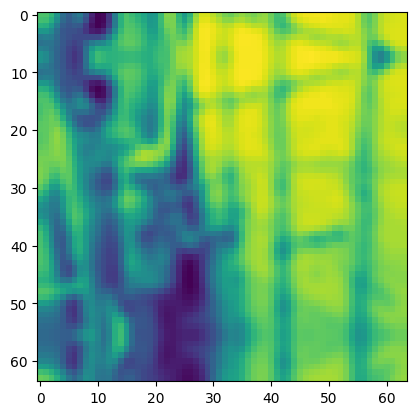

In [ ]:
plt.imshow(images_gray_blur[3]);

SPLITTING IN PREPROCESSED DATA

In [ ]:
X_train_pre, X_temp_pre, y_train_pre, y_temp_pre = train_test_split(images_gray_blur,labels , test_size=0.2, random_state=42,stratify=labels)
# Splitting the temporary set further into validation (50%) and test (50%) sets
# This results in 10% validation and 10% test data from the original dataset
X_val_pre, X_test_pre, y_val_pre, y_test_pre = train_test_split(X_temp_pre,y_temp_pre , test_size=0.5, random_state=42,stratify=y_temp_pre)

Encoding the traget varibale

In [ ]:
from sklearn.preprocessing import LabelBinarizer

enc = LabelBinarizer()

y_train_encoded = enc.fit_transform(y_train_rgb)
y_val_encoded   = enc.transform(y_val_rgb)
y_test_encoded  = enc.transform(y_test_rgb)

In [ ]:
print(enc.classes_)

[0 1]


DATA NORMALIZATION

In [ ]:
# Normalizing the image pixels
X_train_rgb = X_train_rgb.astype('float32')/255.0
X_val_rgb = X_val_rgb.astype('float32')/255.0
X_test_rgb = X_test_rgb.astype('float32')/255.0

In [ ]:
np.unique(X_train_rgb)

array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.01568628,
       0.01960784, 0.02352941, 0.02745098, 0.03137255, 0.03529412,
       0.03921569, 0.04313726, 0.04705882, 0.05098039, 0.05490196,
       0.05882353, 0.0627451 , 0.06666667, 0.07058824, 0.07450981,
       0.07843138, 0.08235294, 0.08627451, 0.09019608, 0.09411765,
       0.09803922, 0.10196079, 0.10588235, 0.10980392, 0.11372549,
       0.11764706, 0.12156863, 0.1254902 , 0.12941177, 0.13333334,
       0.13725491, 0.14117648, 0.14509805, 0.14901961, 0.15294118,
       0.15686275, 0.16078432, 0.16470589, 0.16862746, 0.17254902,
       0.1764706 , 0.18039216, 0.18431373, 0.1882353 , 0.19215687,
       0.19607843, 0.2       , 0.20392157, 0.20784314, 0.21176471,
       0.21568628, 0.21960784, 0.22352941, 0.22745098, 0.23137255,
       0.23529412, 0.23921569, 0.24313726, 0.24705882, 0.2509804 ,
       0.25490198, 0.25882354, 0.2627451 , 0.26666668, 0.27058825,
       0.27450982, 0.2784314 , 0.28235295, 0.28627452, 0.29019

In [ ]:
# Normalizing the image pixels
X_train_pre = X_train_pre.astype('float32')/255.0
X_val_pre = X_val_pre.astype('float32')/255.0
X_test_pre = X_test_pre.astype('float32')/255.0

In [ ]:
print(f'The size of X_train_rgb is :{X_train_rgb.shape}')
print(f'The size of X_val_rgb is :{X_val_rgb.shape}')
print(f'The size of X_test_rgb is :{X_test_rgb.shape}')


The size of X_train_rgb is :(504, 64, 64, 3)
The size of X_val_rgb is :(63, 64, 64, 3)
The size of X_test_rgb is :(64, 64, 64, 3)


In [ ]:
print(f'The size of the x_train_pre is :{X_train_pre.shape}')
print(f'The size of the x_val_pre is :{X_val_pre.shape}')
print(f'The size of the x_test_pre is :{X_test_pre.shape}')

The size of the x_train_pre is :(504, 64, 64)
The size of the x_val_pre is :(63, 64, 64)
The size of the x_test_pre is :(64, 64, 64)


In [ ]:
print(f'The minimum and maximum value of X_train_rgb is:{X_train_rgb.min(),X_train_rgb.max()}')
print(f'The minimum and maximum value of X_val_rgb is:{X_val_rgb.min(),X_val_rgb.max()}')
print(f'The minimum and maximum value of X_test_rgb is:{X_test_rgb.min(),X_test_rgb.max()}')

The minimum and maximum value of X_train_rgb is:(np.float32(0.0), np.float32(1.0))
The minimum and maximum value of X_val_rgb is:(np.float32(0.0), np.float32(1.0))
The minimum and maximum value of X_test_rgb is:(np.float32(0.0), np.float32(1.0))


In [ ]:
print(f'The minimum and maximum value of X_train_rgb is:{X_train_pre.min(),X_train_pre.max()}')
print(f'The minimum and maximum value of X_val_rgb is:{X_val_pre.min(),X_val_pre.max()}')
print(f'The minimum and maximum value of X_test_rgb is:{X_test_pre.min(),X_test_pre.max()}')

The minimum and maximum value of X_train_rgb is:(np.float32(0.0), np.float32(1.0))
The minimum and maximum value of X_val_rgb is:(np.float32(0.0), np.float32(1.0))
The minimum and maximum value of X_test_rgb is:(np.float32(0.0), np.float32(1.0))


MODEL BUILDING

UTILITY FUNCTIONS

In [ ]:
def model_performance_classification(model, predictors, target):
    """
    Simplified performance metrics function for binary classification.

    model: Trained Keras model
    predictors: Input features
    target: True binary labels (0 or 1)
    """
    pred_probs = model.predict(predictors)
    preds = (pred_probs > 0.5).astype(int).flatten()  # Simple thresholding

    # Flatten target if it's shaped (N,1)
    target = target.flatten()

    acc = accuracy_score(target, preds)
    recall = recall_score(target, preds)
    precision = precision_score(target, preds)
    f1 = f1_score(target, preds)

    df_perf = pd.DataFrame({
        "Accuracy": [acc],
        "Recall": [recall],
        "Precision": [precision],
        "F1 Score": [f1]
    })

    return df_perf

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix_binary(model, predictors, target):
    """
    Plot confusion matrix for binary classification model.

    model: Trained Keras model
    predictors: Input features (X)
    target: True binary labels (y)
    """
    # Predict class probabilities
    pred_probs = model.predict(predictors)

    # Convert probabilities to class labels (0 or 1)
    preds = (pred_probs > 0.5).astype(int).flatten()
    target = target.flatten()

    # Compute confusion matrix
    cm = confusion_matrix(target, preds)

    # Plot
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Helmet', 'Helmet'], yticklabels=['No Helmet', 'Helmet'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Binary Classification')
    plt.show()

ANN WITH RGB IMAGES

In [ ]:
# Import necessary modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Step 1: Define input shape
input_shape = (64, 64, 3)  # For RGB images

# Step 2: Build the model
model_rgb_ann = Sequential()
model_rgb_ann.add(Input(shape=input_shape))                   # Input Layer
model_rgb_ann.add(Flatten())                                  # Flatten Layer
model_rgb_ann.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model_rgb_ann.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_rgb_ann.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model_rgb_ann.add(Dense(1, activation='sigmoid'))             # Output layer for binary classification

# Step 3: Compile the model
model_rgb_ann.compile(optimizer=Adam(learning_rate=0.001),
                      loss='binary_crossentropy',
                      metrics=['Recall'])

# Step 4: Print model summary
model_rgb_ann.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,145,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,187,201 (12.16 MB)

 Trainable params: 3,187,201 (12.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_rgb_ann = model_rgb_ann.fit(
    X_train_rgb,                # Training images (RGB, shape: N, 64, 64, 3)
    y_train_encoded,            # Binary labels (shape: N, 1)
    validation_data=(X_val_rgb, y_val_encoded),  # Validation set
    epochs=15,                  # Number of epochs (adjust as needed)
    batch_size=32,              # Batch size (can be 64 or 128 if more RAM)
    verbose=2                   # Print output during training
)

Epoch 1/15
16/16 - 3s - 169ms/step - Recall: 0.5847 - loss: 1.6122 - val_Recall: 0.8065 - val_loss: 0.3255
Epoch 2/15
16/16 - 1s - 41ms/step - Recall: 0.7419 - loss: 0.4195 - val_Recall: 1.0000 - val_loss: 0.6960
Epoch 3/15
16/16 - 1s - 41ms/step - Recall: 0.8468 - loss: 0.3241 - val_Recall: 1.0000 - val_loss: 0.6713
Epoch 4/15
16/16 - 1s - 40ms/step - Recall: 0.8427 - loss: 0.3406 - val_Recall: 1.0000 - val_loss: 0.6976
Epoch 5/15
16/16 - 1s - 39ms/step - Recall: 0.7944 - loss: 0.4406 - val_Recall: 0.9355 - val_loss: 0.3588
Epoch 6/15
16/16 - 1s - 41ms/step - Recall: 0.8185 - loss: 0.5530 - val_Recall: 0.6774 - val_loss: 0.3207
Epoch 7/15
16/16 - 1s - 92ms/step - Recall: 0.8871 - loss: 0.3032 - val_Recall: 0.7742 - val_loss: 0.2502
Epoch 8/15
16/16 - 1s - 80ms/step - Recall: 0.8750 - loss: 0.2595 - val_Recall: 0.7742 - val_loss: 0.2560
Epoch 9/15
16/16 - 1s - 48ms/step - Recall: 0.9073 - loss: 0.3040 - val_Recall: 0.7419 - val_loss: 0.3274
Epoch 10/15
16/16 - 1s - 38ms/step - Recall: 

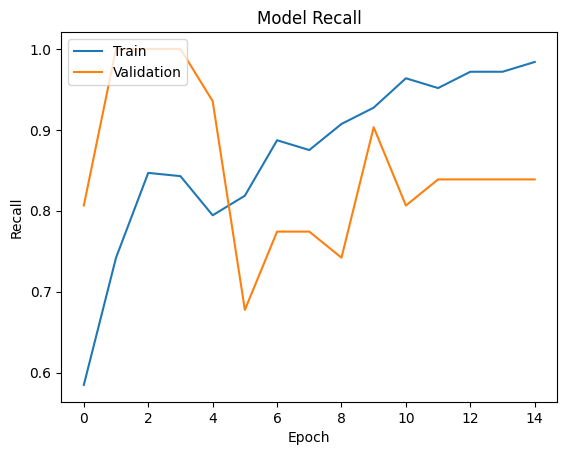

In [ ]:
plt.plot(history_rgb_ann.history['Recall'])
plt.plot(history_rgb_ann.history['val_Recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_1_train_perf= model_performance_classification(model_rgb_ann, X_train_rgb,y_train_encoded)
model_1_train_perf

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.986111,0.987903,0.983936,0.985915


In [ ]:
model_1_val_perf= model_performance_classification(model_rgb_ann, X_val_rgb,y_val_encoded)
model_1_val_perf

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.904762,0.83871,0.962963,0.896552


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


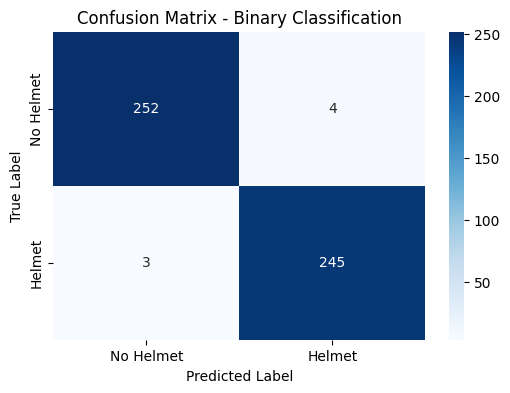

In [ ]:
model_1_train_confusion= plot_confusion_matrix_binary(model_rgb_ann, X_train_rgb,y_train_encoded)

Visualization of Prediction

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


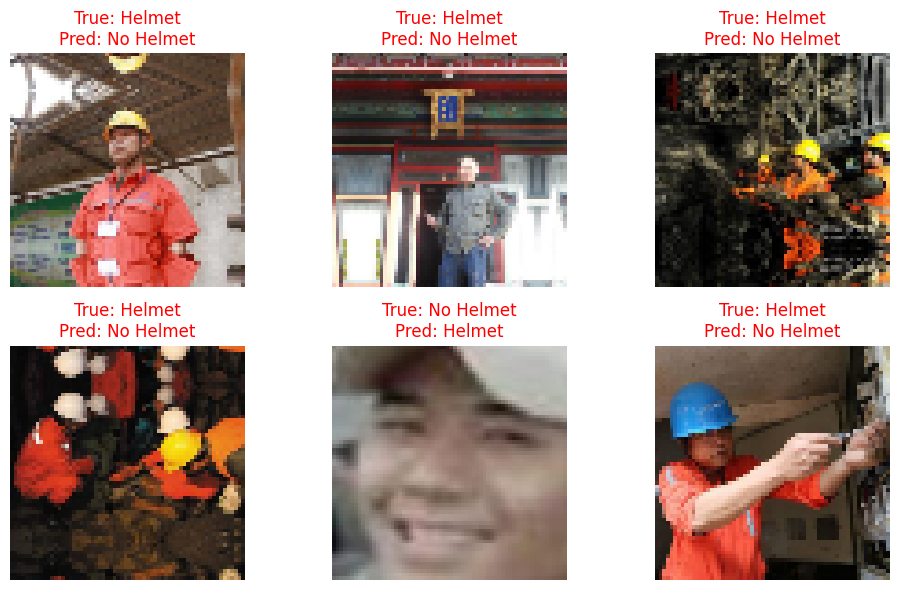

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define class names
class_names = ['No Helmet', 'Helmet']

# Predict on the full validation set
val_probs = model_rgb_ann.predict(X_val_rgb)
val_preds = (val_probs > 0.5).astype(int).flatten()

# Show 6 incorrect predictions
shown = 0
plt.figure(figsize=(10, 6))

for i in range(len(X_val_rgb)):
    if val_preds[i] != y_val_encoded[i][0]:  # Only incorrect
        plt.subplot(2, 3, shown + 1)
        plt.imshow(X_val_rgb[i])
        plt.title(f"True: {class_names[y_val_encoded[i][0]]}\nPred: {class_names[val_preds[i]]}", color='red')
        plt.axis('off')
        shown += 1
        if shown == 6:
            break

plt.tight_layout()
plt.show()


ANN model+ Preprocessed Image

In [ ]:
model_gb_ann = Sequential([
    Flatten(input_shape=(64, 64)),                     # changed: 2D grayscale
    Dense(256, activation='relu', kernel_initializer='he_uniform'),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dense(64,  activation='relu', kernel_initializer='he_uniform'),
    Dense(1,   activation='sigmoid')                   # binary output
])

model_gb_ann.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.Recall(name='recall')]   # focus on recall
)

model_gb_ann.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,090,049 (4.16 MB)

 Trainable params: 1,090,049 (4.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_gb = model_gb_ann.fit(
    X_train_pre, y_train_encoded,
    validation_data=(X_val_pre, y_val_encoded),
    epochs=15,
    batch_size=32,
    verbose=2
)

Epoch 1/15
16/16 - 2s - 118ms/step - loss: 0.7081 - recall: 0.7016 - val_loss: 0.3466 - val_recall: 0.7419
Epoch 2/15
16/16 - 0s - 18ms/step - loss: 0.4685 - recall: 0.7137 - val_loss: 0.6868 - val_recall: 1.0000
Epoch 3/15
16/16 - 0s - 16ms/step - loss: 0.3530 - recall: 0.8226 - val_loss: 0.5041 - val_recall: 1.0000
Epoch 4/15
16/16 - 0s - 19ms/step - loss: 0.3401 - recall: 0.8105 - val_loss: 0.6534 - val_recall: 1.0000
Epoch 5/15
16/16 - 0s - 16ms/step - loss: 0.4429 - recall: 0.7540 - val_loss: 0.3467 - val_recall: 1.0000
Epoch 6/15
16/16 - 0s - 17ms/step - loss: 0.4337 - recall: 0.8145 - val_loss: 0.2082 - val_recall: 0.9032
Epoch 7/15
16/16 - 0s - 17ms/step - loss: 0.2662 - recall: 0.8669 - val_loss: 0.1935 - val_recall: 0.9355
Epoch 8/15
16/16 - 0s - 18ms/step - loss: 0.3099 - recall: 0.8468 - val_loss: 0.1954 - val_recall: 0.9677
Epoch 9/15
16/16 - 0s - 18ms/step - loss: 0.3116 - recall: 0.8831 - val_loss: 0.1802 - val_recall: 0.8710
Epoch 10/15
16/16 - 0s - 17ms/step - loss: 0.

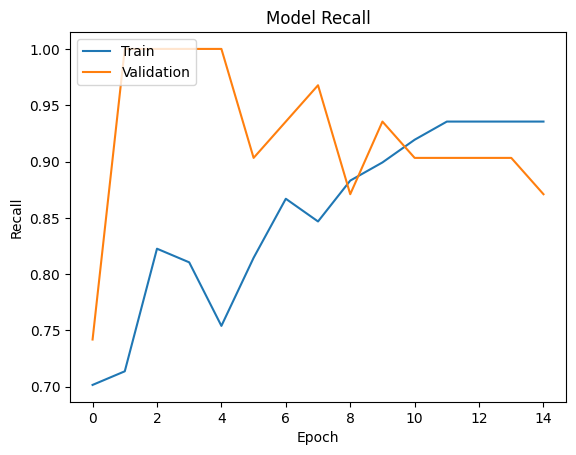

In [ ]:
plt.plot(history_gb.history['recall'])
plt.plot(history_gb.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_2_train_perf= model_performance_classification(model_gb_ann, X_train_pre,y_train_encoded)
model_2_train_perf

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.954365,0.959677,0.948207,0.953908


In [ ]:
model_2_val_perf= model_performance_classification(model_gb_ann, X_val_pre,y_val_encoded)
model_2_val_perf

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.904762,0.870968,0.931034,0.9


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


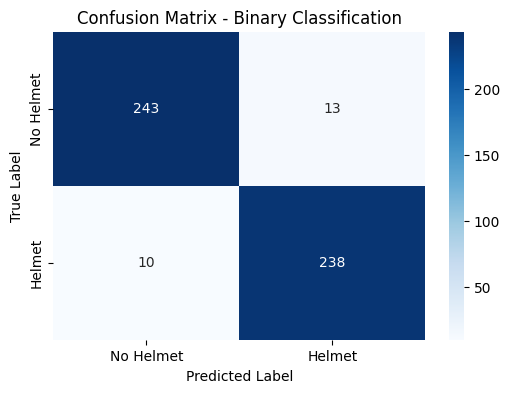

In [ ]:
model_2_train_confusion= plot_confusion_matrix_binary(model_gb_ann, X_train_pre,y_train_encoded)

Visualization of Prediction

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


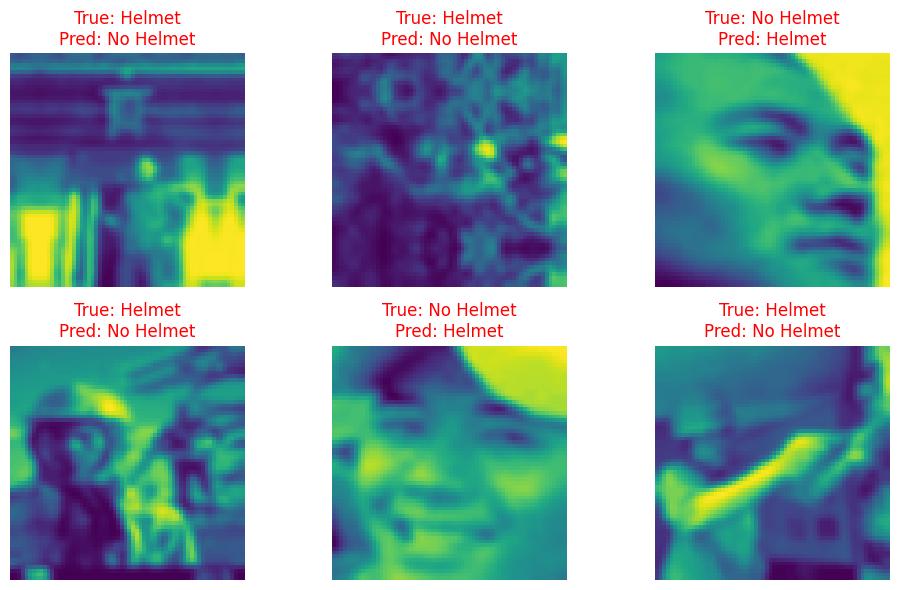

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define class names
class_names = ['No Helmet', 'Helmet']

# Predict on the full validation set
val_probs = model_gb_ann.predict(X_val_pre)
val_preds = (val_probs > 0.5).astype(int).flatten()

# Show 6 incorrect predictions
shown = 0
plt.figure(figsize=(10, 6))

for i in range(len(X_val_pre)):
    if val_preds[i] != y_val_encoded[i][0]:  # Only incorrect
        plt.subplot(2, 3, shown + 1)
        plt.imshow(X_val_pre[i])
        plt.title(f"True: {class_names[y_val_encoded[i][0]]}\nPred: {class_names[val_preds[i]]}", color='red')
        plt.axis('off')
        shown += 1
        if shown == 6:
            break

plt.tight_layout()
plt.show()

CNN BASIC MODEL WITH ORIGINAL DATA

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall

# Step 1: Define input shape
input_shape = (64, 64, 3)  # Use (64, 64, 1) for grayscale images

# Step 2: Build the CNN model
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))  # Binary output

# Step 3: Compile the model with only Recall as the metric
model_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[Recall()]
)

# Step 4: Model summary (optional)
model_cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 30752)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     1,968,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,969,153 (7.51 MB)

 Trainable params: 1,969,153 (7.51 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_cnn = model_cnn.fit(
    X_train_rgb, y_train_encoded,
    validation_data=(X_val_rgb, y_val_encoded),
    epochs=15,
    batch_size=32,
    verbose=2
)

Epoch 1/15
16/16 - 4s - 246ms/step - loss: 0.7900 - recall_1: 0.7984 - val_loss: 0.2611 - val_recall_1: 1.0000
Epoch 2/15
16/16 - 1s - 81ms/step - loss: 0.1509 - recall_1: 0.9556 - val_loss: 0.1149 - val_recall_1: 0.9355
Epoch 3/15
16/16 - 1s - 81ms/step - loss: 0.0837 - recall_1: 0.9758 - val_loss: 0.0354 - val_recall_1: 1.0000
Epoch 4/15
16/16 - 3s - 167ms/step - loss: 0.0397 - recall_1: 0.9919 - val_loss: 0.0410 - val_recall_1: 0.9677
Epoch 5/15
16/16 - 1s - 83ms/step - loss: 0.0299 - recall_1: 0.9960 - val_loss: 0.0450 - val_recall_1: 0.9677
Epoch 6/15
16/16 - 1s - 82ms/step - loss: 0.0206 - recall_1: 1.0000 - val_loss: 0.0383 - val_recall_1: 0.9677
Epoch 7/15
16/16 - 2s - 117ms/step - loss: 0.0149 - recall_1: 1.0000 - val_loss: 0.0387 - val_recall_1: 0.9677
Epoch 8/15
16/16 - 3s - 166ms/step - loss: 0.0117 - recall_1: 1.0000 - val_loss: 0.0363 - val_recall_1: 0.9677
Epoch 9/15
16/16 - 1s - 83ms/step - loss: 0.0093 - recall_1: 1.0000 - val_loss: 0.0361 - val_recall_1: 0.9677
Epoch 

In [ ]:
print(history_cnn.history.keys())

dict_keys(['loss', 'recall_1', 'val_loss', 'val_recall_1'])


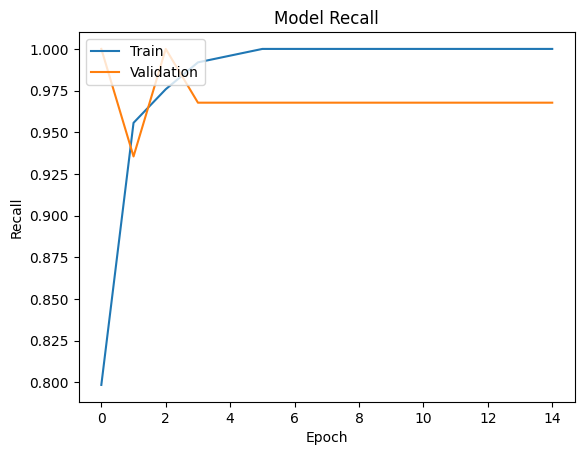

In [ ]:
plt.plot(history_cnn.history['recall_1'])
plt.plot(history_cnn.history['val_recall_1'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_3_train_perf= model_performance_classification(model_cnn, X_train_rgb,y_train_encoded)
model_3_train_perf

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


,Accuracy,Recall,Precision,F1 Score
0,1.0,1.0,1.0,1.0


In [ ]:
model_3_val_perf= model_performance_classification(model_cnn, X_val_rgb,y_val_encoded)
model_3_val_perf

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.984127,0.967742,1.0,0.983607


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


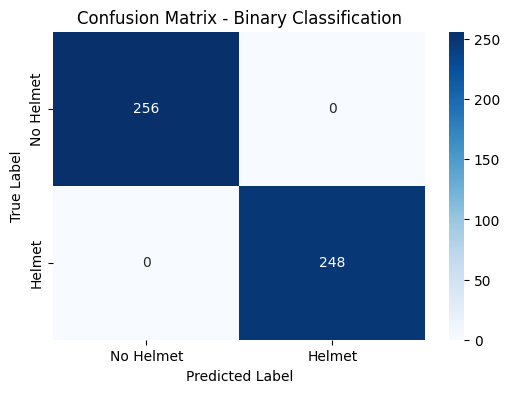

In [ ]:
model_3_train_confusion= plot_confusion_matrix_binary(model_cnn, X_train_rgb,y_train_encoded)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


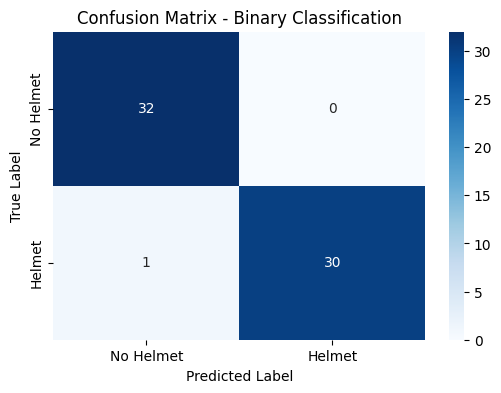

In [ ]:
model_3_validation_confusion= plot_confusion_matrix_binary(model_cnn, X_val_rgb,y_val_encoded)

# Visualization of Prediction

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


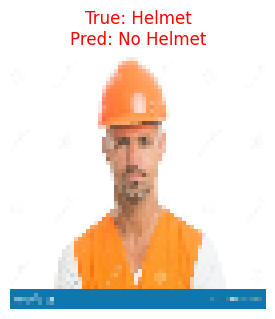

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define class names
class_names = ['No Helmet', 'Helmet']

# Predict on the full validation set
val_probs = model_cnn.predict(X_val_rgb)
val_preds = (val_probs > 0.5).astype(int).flatten()

# Show 6 incorrect predictions
shown = 0
plt.figure(figsize=(10, 6))

for i in range(len(X_val_rgb)):
    if val_preds[i] != y_val_encoded[i][0]:  # Only incorrect
        plt.subplot(2, 3, shown + 1)
        plt.imshow(X_val_rgb[i])
        plt.title(f"True: {class_names[y_val_encoded[i][0]]}\nPred: {class_names[val_preds[i]]}", color='red')
        plt.axis('off')
        shown += 1
        if shown == 6:
            break

plt.tight_layout()
plt.show()

VGG-16 +FNN

In [ ]:
vgg_base = VGG16(weights='imagenet',
                 include_top=False,        # Exclude the default fully connected layers
                 input_shape=(64, 64, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for layer in vgg_base.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input

# Start building the full model
from tensorflow.keras import Sequential

model_4= Sequential()
model_4.add(vgg_base)
model_4.add(Flatten())
model_4.add(Dense(256, activation='relu'))
model_4.add(Dropout(0.5))                   # Optional: helps prevent overfitting
model_4.add(Dense(1, activation='sigmoid'))

In [ ]:
from tensorflow.keras.optimizers import Adam

model_4.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['Recall'])

In [ ]:
history_VGG_16_FFN=model_4.fit(X_train_rgb, y_train_encoded,
          validation_data=(X_val_rgb, y_val_encoded),
          epochs=15,
          batch_size=32)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - Recall: 0.7643 - loss: 0.5459 - val_Recall: 1.0000 - val_loss: 0.2380
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - Recall: 0.9087 - loss: 0.2413 - val_Recall: 1.0000 - val_loss: 0.1111
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - Recall: 0.9825 - loss: 0.1128 - val_Recall: 1.0000 - val_loss: 0.0708
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - Recall: 0.9708 - loss: 0.0973 - val_Recall: 1.0000 - val_loss: 0.0479
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - Recall: 0.9891 - loss: 0.0486 - val_Recall: 1.0000 - val_loss: 0.0382
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - Recall: 0.9828 - loss: 0.0444 - val_Recall: 1.0000 - val_loss: 0.0293
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - Recall: 0.9995 - loss: 0.0294 - val_Recall: 1.0000 - val_loss: 0.0240
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - Recall: 0.9927 - loss: 0.0286 - val_Recall: 1.0000 - val_loss: 0.0201
Epoch 9/15
16/16 ━━━━━━━

In [ ]:
print(history_VGG_16_FFN.history.keys())

dict_keys(['Recall', 'loss', 'val_Recall', 'val_loss'])


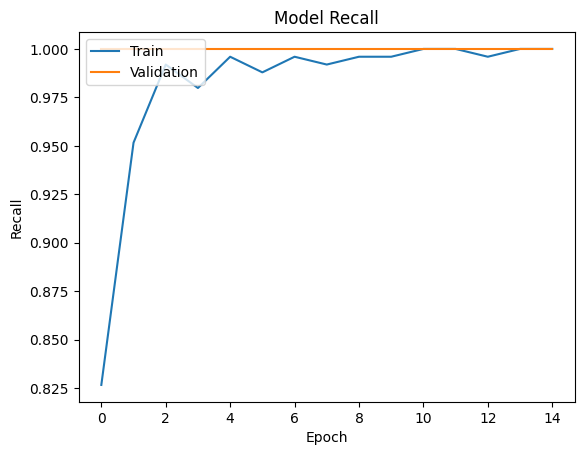

In [ ]:
plt.plot(history_VGG_16_FFN.history['Recall'])
plt.plot(history_VGG_16_FFN.history['val_Recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_4_train_perf= model_performance_classification(model_4, X_train_rgb,y_train_encoded)
model_4_train_perf

16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step


,Accuracy,Recall,Precision,F1 Score
0,1.0,1.0,1.0,1.0


In [ ]:
model_4_val_perf= model_performance_classification(model_4, X_val_rgb,y_val_encoded)
model_4_val_perf

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


,Accuracy,Recall,Precision,F1 Score
0,1.0,1.0,1.0,1.0


16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step


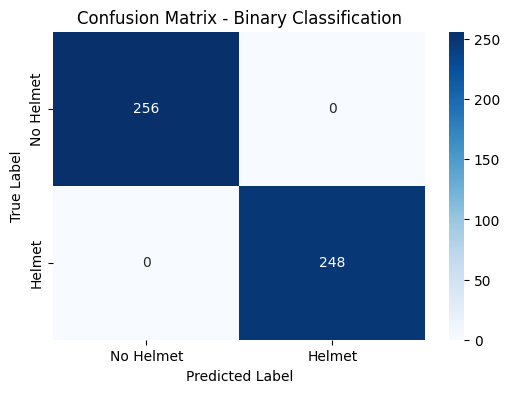

In [ ]:
model_4_train_confusion= plot_confusion_matrix_binary(model_4, X_train_rgb,y_train_encoded)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


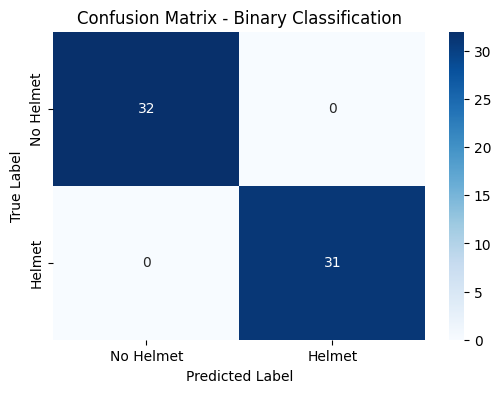

In [ ]:
model_4_validation_confusion= plot_confusion_matrix_binary(model_4, X_val_rgb,y_val_encoded)

Prediction Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


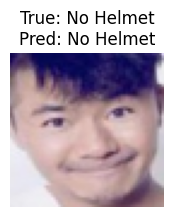

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


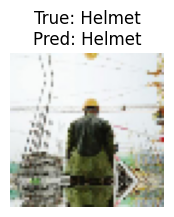

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Class names based on label encoding
class_names = ['No Helmet', 'Helmet']

# ---------- IMAGE 1 ----------
index_1 = 5  # manually choose an index (e.g. 5)
image_1 = X_val_rgb[index_1]
true_label_1 = y_val_encoded[index_1][0]

# Make prediction
prediction_1 = model_4.predict(image_1.reshape(1, 64, 64, 3))
predicted_label_1 = int(prediction_1 >= 0.5)

# Show image
plt.figure(figsize=(2, 2))
plt.imshow(image_1)
plt.axis('off')
plt.title(f"True: {class_names[true_label_1]}\nPred: {class_names[predicted_label_1]}")
plt.show()

# ---------- IMAGE 2 ----------
index_2 = 12  # manually choose another index
image_2 = X_val_rgb[index_2]
true_label_2 = y_val_encoded[index_2][0]

# Make prediction
prediction_2 = model_4.predict(image_2.reshape(1, 64, 64, 3))
predicted_label_2 = int(prediction_2 >= 0.5)

# Show image
plt.figure(figsize=(2, 2))
plt.imshow(image_2)
plt.axis('off')
plt.title(f"True: {class_names[true_label_2]}\nPred: {class_names[predicted_label_2]}")
plt.show()

VGG-16 + DATA AGUMENTATION

In [ ]:
model_5 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model_5.add(vgg_base)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_5.add(Flatten())

#Adding the Feed Forward neural network
model_5.add(Dense(256,activation='relu'))
model_5.add(Dropout(rate=0.4))
model_5.add(Dense(32,activation='relu'))

# Adding a dense output layer
model_5.add(Dense(1, activation='sigmoid'))

In [ ]:
from tensorflow.keras.optimizers import Adam

model_5.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['Recall'])

In [ ]:
model_5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,247,489 (58.16 MB)

 Trainable params: 532,801 (2.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=20,          # Random rotation between 0 and 20 degrees
    width_shift_range=0.2,      # Random horizontal shifts
    height_shift_range=0.2,     # Random vertical shifts
    shear_range=0.3,            # Shear transformation
    zoom_range=0.4,             # Random zoom
    horizontal_flip=True,       # Flip images horizontally
    fill_mode='nearest'         # Fill in missing pixels after transformation
)

In [ ]:
train_generator = train_datagen.flow(
    X_train_rgb,
    y_train_encoded,
    batch_size=32,
    shuffle=False   # Turn off shuffling
)


In [ ]:
history_VGG_aug = model_5.fit(
    train_generator,
    validation_data=(X_val_rgb, y_val_encoded),
    epochs=15,
    verbose=2
)

Epoch 1/15
16/16 - 28s - 2s/step - Recall: 0.6089 - loss: 0.6398 - val_Recall: 0.8387 - val_loss: 0.4446
Epoch 2/15
16/16 - 41s - 3s/step - Recall: 0.8710 - loss: 0.4621 - val_Recall: 0.9355 - val_loss: 0.2539
Epoch 3/15
16/16 - 28s - 2s/step - Recall: 0.9113 - loss: 0.2904 - val_Recall: 0.9677 - val_loss: 0.1463
Epoch 4/15
16/16 - 26s - 2s/step - Recall: 0.9556 - loss: 0.1954 - val_Recall: 0.9677 - val_loss: 0.0886
Epoch 5/15
16/16 - 24s - 1s/step - Recall: 0.9597 - loss: 0.1502 - val_Recall: 0.9677 - val_loss: 0.0605
Epoch 6/15
16/16 - 43s - 3s/step - Recall: 0.9677 - loss: 0.1043 - val_Recall: 0.9677 - val_loss: 0.0425
Epoch 7/15
16/16 - 41s - 3s/step - Recall: 0.9798 - loss: 0.0883 - val_Recall: 0.9677 - val_loss: 0.0393
Epoch 8/15
16/16 - 40s - 2s/step - Recall: 0.9839 - loss: 0.0695 - val_Recall: 0.9677 - val_loss: 0.0336
Epoch 9/15
16/16 - 24s - 1s/step - Recall: 0.9677 - loss: 0.0876 - val_Recall: 1.0000 - val_loss: 0.0194
Epoch 10/15
16/16 - 43s - 3s/step - Recall: 0.9798 - lo

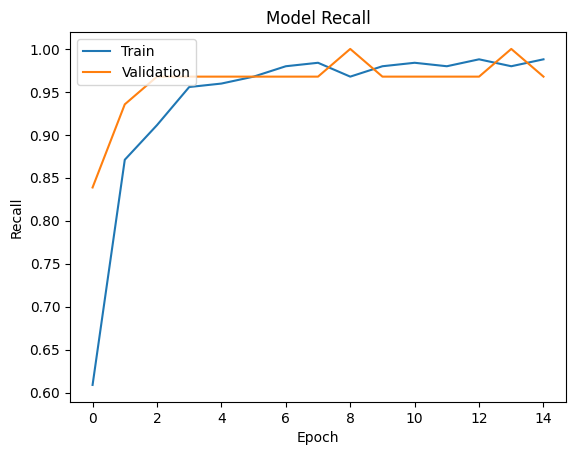

In [ ]:
plt.plot(history_VGG_aug.history['Recall'])
plt.plot(history_VGG_aug.history['val_Recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_5_train_perf= model_performance_classification(model_5, X_train_rgb,y_train_encoded)
model_5_train_perf

16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step


,Accuracy,Recall,Precision,F1 Score
0,0.998016,1.0,0.995984,0.997988


In [ ]:
model_5_val_perf= model_performance_classification(model_5, X_val_rgb,y_val_encoded)
model_5_val_perf

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


,Accuracy,Recall,Precision,F1 Score
0,0.984127,0.967742,1.0,0.983607


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


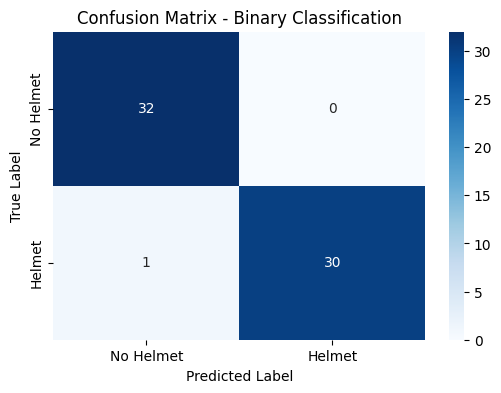

In [ ]:
model_5_validation_confusion= plot_confusion_matrix_binary(model_5, X_val_rgb,y_val_encoded)

Visualizing prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


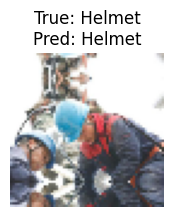

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


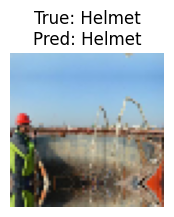

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Class names based on label encoding
class_names = ['No Helmet', 'Helmet']

# ---------- IMAGE 1 ----------
index_1 = 6  # manually choose an index (e.g. 5)
image_1 = X_val_rgb[index_1]
true_label_1 = y_val_encoded[index_1][0]

# Make prediction
prediction_1 = model_5.predict(image_1.reshape(1, 64, 64, 3))
predicted_label_1 = int(prediction_1 >= 0.5)

# Show image
plt.figure(figsize=(2, 2))
plt.imshow(image_1)
plt.axis('off')
plt.title(f"True: {class_names[true_label_1]}\nPred: {class_names[predicted_label_1]}")
plt.show()

# ---------- IMAGE 2 ----------
index_2 = 9  # manually choose another index
image_2 = X_val_rgb[index_2]
true_label_2 = y_val_encoded[index_2][0]

# Make prediction
prediction_2 = model_5.predict(image_2.reshape(1, 64, 64, 3))
predicted_label_2 = int(prediction_2 >= 0.5)

# Show image
plt.figure(figsize=(2, 2))
plt.imshow(image_2)
plt.axis('off')
plt.title(f"True: {class_names[true_label_2]}\nPred: {class_names[predicted_label_2]}")
plt.show()

TRAINING AND VALIDATION PERFORMANCE

In [ ]:
models_train_comp_df = pd.concat(
    [
        model_1_train_perf.T,
        model_2_train_perf.T,
        model_3_train_perf.T,
        model_4_train_perf.T,
        model_5_train_perf.T
    ],
    axis=1,
)
models_train_comp_df.columns = [
    " ANN with RGB Images","ANN Model+Preprocessed Image","CNN BASIC MODEL with Original Data ","VGG-16 +FNN","VGG-16 + DATA AGUMENTATION"
]
models_train_comp_df


,ANN with RGB Images,ANN Model+Preprocessed Image,CNN BASIC MODEL with Original Data,VGG-16 +FNN,VGG-16 + DATA AGUMENTATION
Accuracy,0.986111,0.954365,1.0,1.0,0.998016
Recall,0.987903,0.959677,1.0,1.0,1.000000
Precision,0.983936,0.948207,1.0,1.0,0.995984
F1 Score,0.985915,0.953908,1.0,1.0,0.997988


In [ ]:
models_validation_comp_df = pd.concat(
    [
        model_1_val_perf.T,
        model_2_val_perf.T,
        model_3_val_perf.T,
        model_4_val_perf.T,
        model_5_val_perf.T
    ],
    axis=1,
)
models_validation_comp_df.columns = [
    " ANN with RGB Images","ANN Model+Preprocessed Image","CNN BASIC MODEL with Original Data ","VGG-16 +FNN","VGG-16 + DATA AGUMENTATION"
]
models_validation_comp_df


,ANN with RGB Images,ANN Model+Preprocessed Image,CNN BASIC MODEL with Original Data,VGG-16 +FNN,VGG-16 + DATA AGUMENTATION
Accuracy,0.904762,0.904762,0.984127,1.0,0.984127
Recall,0.838710,0.870968,0.967742,1.0,0.967742
Precision,0.962963,0.931034,1.000000,1.0,1.000000
F1 Score,0.896552,0.900000,0.983607,1.0,0.983607


In [ ]:
models_train_comp_df - models_validation_comp_df

,ANN with RGB Images,ANN Model+Preprocessed Image,CNN BASIC MODEL with Original Data,VGG-16 +FNN,VGG-16 + DATA AGUMENTATION
Accuracy,0.081349,0.049603,0.015873,0.0,0.013889
Recall,0.149194,0.088710,0.032258,0.0,0.032258
Precision,0.020973,0.017173,0.000000,0.0,-0.004016
F1 Score,0.089364,0.053908,0.016393,0.0,0.014381


FINAL MODEL VGG-16+ DATA AUGUMENTATION

In [ ]:
model_5_test_performance= model_performance_classification(model_5, X_test_rgb,y_test_encoded)
model_5_test_performance

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


,Accuracy,Recall,Precision,F1 Score
0,1.0,1.0,1.0,1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


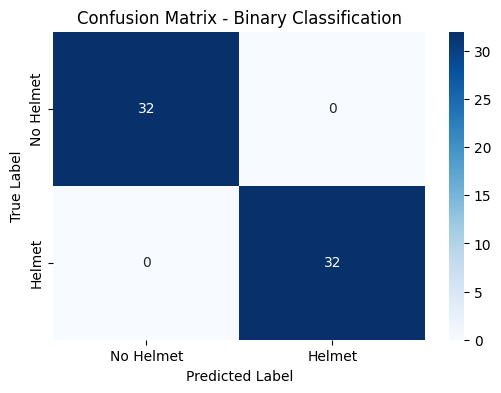

In [ ]:
model_5_test_confusion= plot_confusion_matrix_binary(model_5, X_test_rgb,y_test_encoded)